<AxesSubplot:title={'center':'한글폰트'}>

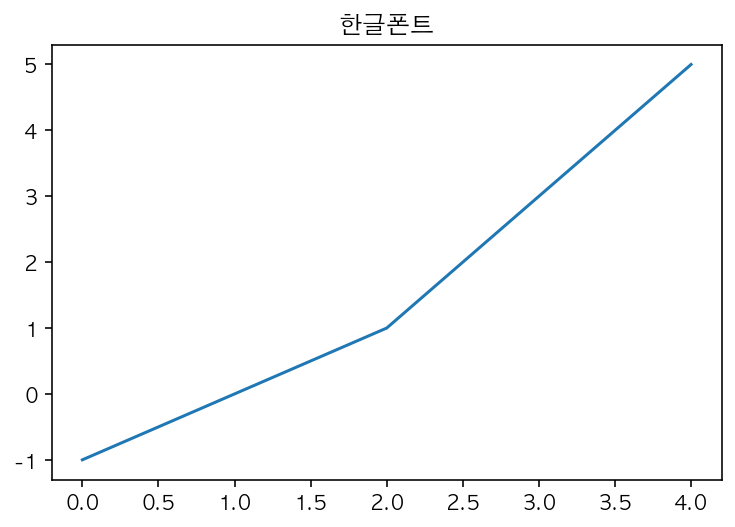

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import set_matplotlib_formats

%matplotlib inline

plt.rc("font", family="AppleGothic")
plt.rc("axes", unicode_minus=False)
set_matplotlib_formats("retina")

pd.Series([-1, 0, 1, 3, 5]).plot(title="한글폰트")

In [2]:
df = pd.read_csv("data/store.csv", sep='|')
columns = ['상호명', '상권업종대분류명', '상권업종중분류명', '상권업종소분류명', 
           '시도명', '시군구명', '행정동명', '법정동명', '도로명주소', 
           '경도', '위도']

df = df[columns].copy()
df.shape

(573680, 11)

In [3]:
df_seoul = df[df["시도명"] == "서울특별시"].copy()
df_seoul.shape

(407376, 11)

In [4]:
df_seoul["상호명_소문자"] = df_seoul["상호명"].str.lower()
print(df_seoul.loc[df_seoul["상호명_소문자"].str.contains("이디야|이디아|ediya"), "상호명_소문자"].shape)
print(df_seoul.loc[df_seoul["상호명_소문자"].str.contains("스타벅스|starbucks"), "상호명_소문자"].shape)
df_cafe = df_seoul[df_seoul["상호명_소문자"].str.contains('스타벅스|starbucks|이디야|이디아|ediya')].copy()
print(df_cafe.shape)

(543,)
(506,)
(1049, 12)


In [5]:
df_cafe.loc[df_cafe["상호명_소문자"].str.contains('스타벅스|starbucks'), "브랜드명"] = "스타벅스"
df_cafe.loc[~df_cafe["상호명_소문자"].str.contains('스타벅스|starbucks'), "브랜드명"] = "이디야"
df_cafe[["상호명_소문자", "브랜드명"]].head()

,상호명_소문자,브랜드명
1104,스타벅스,스타벅스
1675,이디야커피,이디야
2023,스타벅스종로3가점,스타벅스
2770,스타벅스,스타벅스
2957,이디야커피,이디야


In [6]:
df_cafe_vs = df_cafe.groupby(["시군구명", "브랜드명"])["상호명"].count()
df_cafe_vs = df_cafe_vs.reset_index()
df_cafe_vs.columns = ['구', '브랜드명', '매장수']
df_cafe_vs.head()

,구,브랜드명,매장수
0,강남구,스타벅스,84
1,강남구,이디야,50
2,강동구,스타벅스,13
3,강동구,이디야,14
4,강북구,스타벅스,5


<AxesSubplot:xlabel='시군구명'>

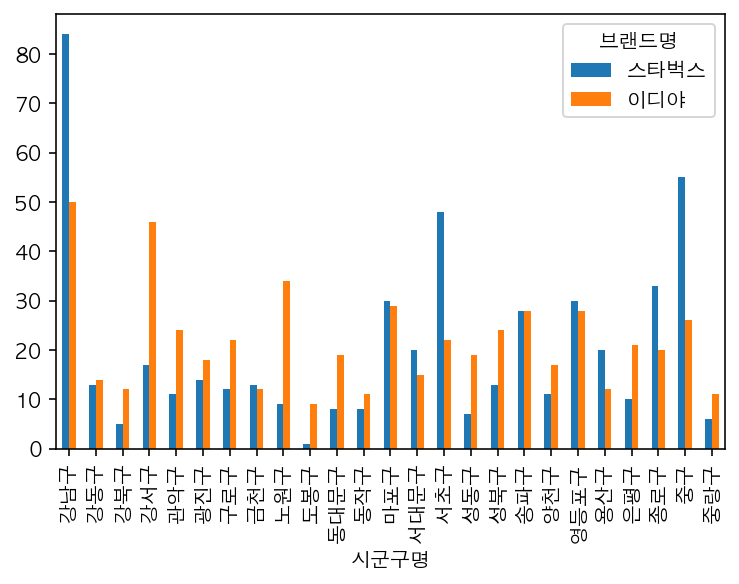

In [7]:
df_cafe.groupby(["시군구명", "브랜드명"])["상호명"].count().unstack().plot.bar()


In [8]:
import folium
import json

geo_path = 'data/seoul_municipalities_geo_simple.json'

geo_json = json.load(open(geo_path, encoding="utf-8"))
geo_json["features"][0]['properties']["name"]

'강동구'

In [9]:
df_star = df_cafe_vs[df_cafe_vs["브랜드명"] == "스타벅스"].copy()
df_star.head()

,구,브랜드명,매장수
0,강남구,스타벅스,84
2,강동구,스타벅스,13
4,강북구,스타벅스,5
6,강서구,스타벅스,17
8,관악구,스타벅스,11


In [10]:
lat = df_cafe["위도"].mean()
long = df_cafe["경도"].mean()

m = folium.Map([lat, long])

folium.Choropleth(
    geo_data=geo_json,
    name='choropleth',
    data=df_star,
    columns=['구', '매장수'],
    key_on='feature.properties.name',
    fill_color='YlGn',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='스타벅스 매장수'
).add_to(m)

m

In [11]:
df_vs = df_cafe_vs.pivot(index="구", columns="브랜드명", values="매장수")
df_vs["매장수비교"] = (df_vs["스타벅스"] - df_vs["이디야"] > 0).astype(float)
df_vs = df_vs.reset_index()
df_vs.head()

브랜드명,구,스타벅스,이디야,매장수비교
0,강남구,84,50,1.0
1,강동구,13,14,0.0
2,강북구,5,12,0.0
3,강서구,17,46,0.0
4,관악구,11,24,0.0


In [12]:
m = folium.Map([lat, long], tiles='stamen toner')

folium.Choropleth(
    geo_data=geo_json,
    name='choropleth',
    data=df_vs,
    columns=['구', '매장수비교'],
    key_on='feature.properties.name',
    fill_color='BuGn',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='매장수 비교'
).add_to(m)

m

In [13]:
df_gu_mean = df_cafe.pivot_table(index="시군구명", values=["경도", "위도"], aggfunc="mean")
df_gu_mean = df_gu_mean.reset_index()
df_gu_mean.head()

,시군구명,경도,위도
0,강남구,127.046129,37.505744
1,강동구,127.135417,37.540316
2,강북구,127.022897,37.631146
3,강서구,126.837883,37.555966
4,관악구,126.935210,37.482054


In [14]:
df_vs = df_vs.merge(df_gu_mean, how='inner', left_on="구", right_on="시군구명")
df_vs.head()

,구,스타벅스,이디야,매장수비교,시군구명,경도,위도
0,강남구,84,50,1.0,강남구,127.046129,37.505744
1,강동구,13,14,0.0,강동구,127.135417,37.540316
2,강북구,5,12,0.0,강북구,127.022897,37.631146
3,강서구,17,46,0.0,강서구,126.837883,37.555966
4,관악구,11,24,0.0,관악구,126.935210,37.482054


In [15]:
m = folium.Map([lat, long], zoom_start=11, tiles='stamen toner')

folium.Choropleth(
    geo_data=geo_json,
    name='choropleth',
    data=df_vs,
    columns=['구', '매장수비교'],
    key_on='feature.properties.name',
    fill_color='BuGn',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='매장수 비교'
).add_to(m)


for i in df_vs.index:
    sub_long = df_vs.loc[i, "경도"]
    sub_lat = df_vs.loc[i, "위도"]
    
    cafes = ["스타벅스", "이디야"]
    for cafe in cafes:
        cafe_count = df_vs.loc[i, cafe]
        
        gu = df_vs.loc[i, "구"]
        tooltip = f"{gu} {cafe} : {cafe_count}"
        
        radius = np.sqrt(cafe_count) * 3
        
        if cafe == "이디야":
            color = "blue"
            sub_long = sub_long + 0.01
        else:
            color = "green"
            
            
        folium.CircleMarker([sub_lat, sub_long],
                            radius=radius,
                            color=color,
                            fill=True,
                            tooltip=tooltip,
                           ).add_to(m)
        
m